In [1]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

In [2]:
required_fields = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base',
       'taker_buy_quote', 'ignore']

In [3]:
def fetch_binance_15m_1yr(symbol="BTCUSDT", required_columns=None):
    """
    Fetch last 1 year of 15-minute interval OHLCV data from Binance.
    Optionally return only the columns specified in required_columns.
    close_time is always used as index.
    """
    
    base_url = "https://api.binance.com/api/v3/klines"
    interval = "1h"

    # Timezone-aware UTC timestamps
    now_utc = datetime.now(timezone.utc)
    start_dt = now_utc - timedelta(days=365)

    end_time = int(now_utc.timestamp() * 1000)
    start_time = int(start_dt.timestamp() * 1000)

    all_candles = []
    current_start = start_time

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": current_start,
            "endTime": end_time,
            "limit": 1000
        }

        response = requests.get(base_url, params=params)
        data = response.json()

        if not data:
            break

        all_candles.extend(data)

        last_close_time = data[-1][6]
        current_start = last_close_time + 1

        if last_close_time >= end_time:
            break

        time.sleep(0.1)


    # Full Binance kline schema
    columns = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]

    df = pd.DataFrame(all_candles, columns=columns)

    # Convert timestamps
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms", utc=True)

    # Numeric OHLCV
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].astype(float)

    # Filter columns if needed
    if required_columns is not None:
        # Ensure close_time is kept for indexing
        cols = required_columns.copy()
        if "close_time" not in cols:
            cols.append("close_time")  # must keep for index

        df = df[cols]

    # Set close_time as index
    df = df.set_index("close_time")
    df = df.sort_index()

    return df


In [4]:
required_fields = ['open', 'high', 'low', 'close', 'volume', 'open_time']

In [5]:
df = fetch_binance_15m_1yr("BTCUSDT", required_fields)
df.head()


,open,high,low,close,volume,open_time
close_time,,,,,,
2024-12-01 18:59:59.999000+00:00,97299.97,97523.41,97095.23,97118.69,690.43406,2024-12-01 18:00:00+00:00
2024-12-01 19:59:59.999000+00:00,97118.69,97306.59,96958.48,97178.73,602.77541,2024-12-01 19:00:00+00:00
2024-12-01 20:59:59.999000+00:00,97178.73,97200.00,96800.01,97099.99,608.28813,2024-12-01 20:00:00+00:00
2024-12-01 21:59:59.999000+00:00,97099.99,97780.00,97052.16,97767.62,672.45318,2024-12-01 21:00:00+00:00
2024-12-01 22:59:59.999000+00:00,97767.61,97836.00,97384.00,97562.56,769.64210,2024-12-01 22:00:00+00:00


In [6]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'open_time'], dtype='object')


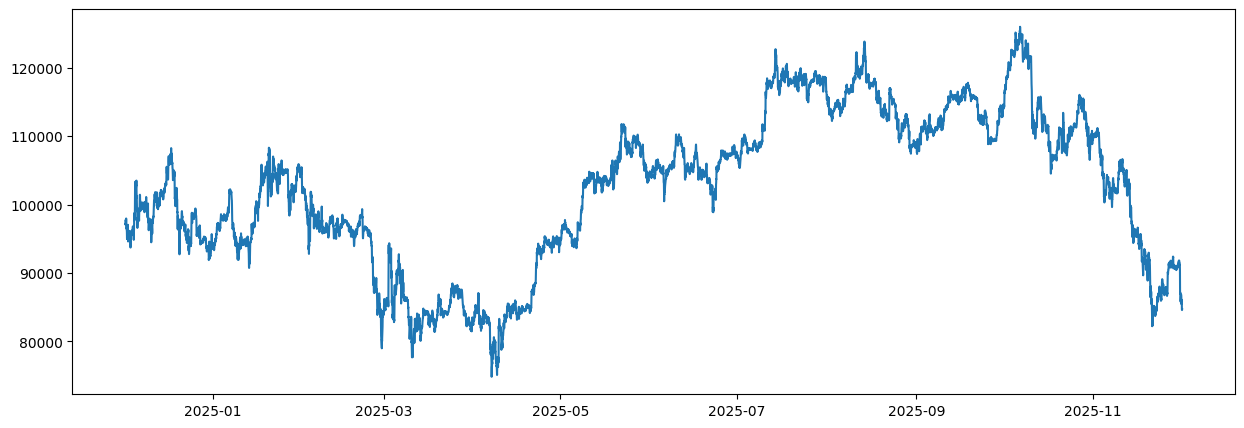

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["close"])

In [8]:
df.to_csv("BTC_1_year_data_1h.csv")